In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Input-Output
import json
from pprint import pprint
import os
import pickle

# Model
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import keras
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *

# Data manipulation
# WARNING, sympy has a re() function which will conflicts with the regex library - "re"
# it is safer to namespace the whole sympy library as "sp"
# import sympy as sp 
import re
import random

# Programmed on
# Keras version 2.0.8
# Tensorflow version 1.3.0
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.0.8
1.3.0


In [2]:
# EXECUTION_MODE = "construct_new_model" # to contruct a new model
EXECUTION_MODE = "load_pretrained_model" # to load a saved model that was trained previously

# OUTPUT_TYPES = "chapter"
OUTPUT_TYPES = "learning_objectives"

LEARNING_OBJECTIVES_ENCODING = "first_used_LO-one_hot"

NUM_OF_LEARNING_OBJECTIVES = 2

if OUTPUT_TYPES == "chapter":
    FILENAME = "model-{}".format(OUTPUT_TYPES)
else:
    FILENAME = "model-{}-{}-{}".format(OUTPUT_TYPES, LEARNING_OBJECTIVES_ENCODING, NUM_OF_LEARNING_OBJECTIVES)

# Global variables that are meant to be updated by the functions
# Before removing brackets was 356
# After removing brackets is 221
MAX_LENGTH = 0;

# Constants for training
MAX_LENGTH_FOR_TRAINING = 221
ENCODING_SIZE_FOR_TRAINING = 42

Click to jump to ["5. Load encoded data and train Model"](http://localhost:8888/notebooks/projects/Workings_to_Meta/Identify_learning_objectives_from_workings.ipynb#5.-Load-encoded-data-and-train-Model)

# 1. Identify Learning Objectives from Student's Working

## 1.1. Goal of this project

This project is a proof-of-concept for possible advancement in the capabilites of the product that I am working on.

The product is a online platform which can let students attempt Maths questions with full workings, and the system will automatically mark every step as correct or wrong.

Currently, the system can mark a working to a question as either fully correct or highlight the mistakes to the students.

However, if a working has been marked as fully correct, the system can not detect if the student had achieved the learnings objectives that had been set in the question.

Every question has been authored with a **set of learning objectives** and the author had provided **a full working that achieved all the learning objectives**.

The learning objectives used in the product are derived from MOE's learning experience for Secondary School Mathematics.

* https://www.moe.gov.sg/docs/default-source/document/education/syllabuses/sciences/files/mathematics-syllabus-sec-1-to-4-express-n(a)-course.pdf#page=34

The goal of this project is to indentify the learning objectives that has been achieved in a working, hence when the student enter his working, the model can be used to predict the learning objectives achieved by him, and match against the learning objectives that was set for the question by the author.



## 1.2. Conclusion

Using a BiDirectional LSTM model to train on the current set of data results in one of two problems:

1. Overfitting when trained to output binary categories
2. Apparently random predictions when trained to output as regression.

This project proves that trying to predict the learning objectives achieved by the students based on his whole working is not feasible.

### 1.2.1. Update after trying "2.0. One-hot encoding for all Chapters"

Instead of trying to train of multiple labels per sample, the models achieve much better accuracies training on a single label.

* **> 80%** accuracy on predicting chapter
* **> 50%** accuracy on predicting a single learning objective

This demostrates that it is feasible to encode a Math expression so that a model can use it as input and achieve meaningful prediction.

It is especially promising because the data used in this project is only one type of data that are assoicated to every questions. There other data in the system that can be associated to the questions and workings which can be used to enchance these models further.

Further work will be done to explore using machine learning to advance the capaibilities of the product.

## 1.3. Further Work

1. Try a All-You-Need-Is-Attention model on the same input and output data.
2. Try to encode the input data into a 2D picture and try to use a CNN model to train on it.
3. Try to build a model to detect the types of equations in a working.
    * While predicting the learning objectives achieved in a whole working might not be feasible,
    * it might still be possible to predict the type of equations on the individual equations in the whole working.
    * Then another model can use the predicted types of equations,
    * to further predict the learning objectives achieved.
    * However, presently, we do not have enough labelled equations to train on this approach.

# 2. Output encoding and model

There are 380 possible learning objectives in the system. Their identifiers start from 1 to 380.

Every question has a set of learning objectives, which can have one or more elements.

The learning objectives in each questions have been arranged from highest to lowest priority.

Three different encoding scheme had been explored, and each scheme will require a different output layer in the Model.

In [3]:
LEARNING_OBJECTIVES_IN_USED = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 19, 20,
    21, 22, 23, 24, 25, 27, 28, 31, 35, 37, 38, 39, 40, 42, 44, 45,
    55, 56, 57, 58, 59, 60, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87,
    88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
    104, 105, 107, 108, 109, 112, 113, 114, 115, 138, 141, 142, 143,
    144, 145, 158, 159, 160, 161, 163, 182, 183, 184, 185, 216, 217,
    218, 219, 220, 223, 224, 226, 280, 281, 282, 283, 285, 289, 290,
    291, 292, 293, 294, 295, 296, 297, 298, 323
]

LEARNING_OBJECTIVES_COUNTER = np.zeros(381, dtype=np.int_).tolist()

def encode_learning_objectives(LOs):
    global LEARNING_OBJECTIVES_COUNTER
    
    if len(LOs) == 0:
        LOs = [0]
    
    for LO in LOs:
        LEARNING_OBJECTIVES_COUNTER[LO] += 1
        
    encoded = {
        "first_LO-one_hot" : [],
        "all_LOs-multi_hot" : [],
        "first_used_LO-one_hot" : [],
        "all_used_LOs-multi_hot" : [],
        "regression" : []
    }
    
    learning_objectives = np.zeros(381, dtype=np.int_)
    learning_objectives[LOs[0]] = 1
    encoded["first_LO-one_hot"] = learning_objectives.tolist()
    
    learning_objectives[LOs] = 1
    encoded["all_LOs-multi_hot"] = learning_objectives.tolist()
    
    learning_objectives = np.zeros(len(LEARNING_OBJECTIVES_IN_USED), dtype=np.int_)
    for idx, LO in enumerate(LOs):
        learning_objectives[LEARNING_OBJECTIVES_IN_USED.index(LO)] = 1
        if idx==0:
            encoded["first_used_LO-one_hot"] = learning_objectives.tolist()
            
    encoded["all_used_LOs-multi_hot"] = learning_objectives.tolist()
    
    learning_objectives = [x/380 for x in LOs]
    encoded["regression"] = learning_objectives
    
    return encoded

# 2.0. One-hot encoding for all Chapters

The earlier results on training for learning objectives were not great.

Hence to try to set a more achieveable goal, I had switched to traiing the model to predicts the chapter that a working is based on.

There are only 15 chapters, as compared to 380 learning objectives, hence this should be an easier goal.

The chapter is simply one-hot encoded.

The output layer of the Model is then configured as such:

```
#!python

output = Dense(15, activation ='softmax')(x)
bidirectional_concat_model = Model(inputs = inp, outputs=output )
bidirectional_concat_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
```

This model achieve **>80% training and validation accuracies**.

This suggests that the input encoding is functional and efficient.

Hence I went back to tweak the model for ["2.2. Binary Categories for used Learning Objectives"](http://localhost:8888/notebooks/projects/Workings_to_Meta/Identify_learning_objectives_%26_chapters_from_workings.ipynb#2.2.-Binary-Categories-for-used-Learning-Objectives). See the update.

In [4]:
def encode_chapter(chapter, size):
    encoded = np.zeros(size, dtype=np.int_)
    encoded[chapter] = 1
    return encoded.tolist()

print(encode_chapter(7, 15))

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


## 2.1. Binary Categories for all Learning Objectives

The obvious choice for encoding the output is binary categories for all 380 learning objectives.

The output layer of the Model is then configured as such:

```
#!python

output = Dense(381, activation ='sigmoid')(x)
bidirectional_concat_model = Model(inputs = inp, outputs=output )
bidirectional_concat_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
```

After some training, it was apparent that there are a few problems

1. The training time is too long.
2. The output is always 21, suggesting that the Model is over-fitting.
3. The accuracy has plateaued at 0.1065, and fluctuates a little.

But most of the learning objectives are not used in the system, and hence are always set to 0.

Hence the learning objectives was trimmed by the encoding scheme - "Binary Categories for used Learning Objectives"

In [5]:
learning_objectives = [1, 3, 5, 7, 101, 216, 323]
encoded = encode_learning_objectives(learning_objectives)
print(np.array(encoded["all_LOs-multi_hot"]).shape)
print(encoded["all_LOs-multi_hot"])

(381,)
[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

## 2.2. Binary Categories for used Learning Objectives

Learning objectives that are not used in the system are removed from the training output.

This reduces the possible output from 380 to 132.

The output layer of the Model is then configured as such:

```
#!python

output = Dense(len(LEARNING_OBJECTIVES_IN_USED), activation ='sigmoid')(x)
bidirectional_concat_model = Model(inputs = inp, outputs=output )
bidirectional_concat_model.compile(loss='binary_"crossentropy', optimizer=adam, metrics=['accuracy'])
```

After some training, it was apparent that there are a few problems

1. The output is always 21, suggesting that the Model is over-fitting.
2. The accuracy has plateaued at around 0.1065, and fluctuates a little.

To totally avoid over-fitting,  the output is forced to become a single value, hence the next encoding scheme is used - "Linear Regression for the first N Learning Objectives"

In [6]:
learning_objectives = [1, 3, 5, 7, 101, 216, 323]
encoded = encode_learning_objectives(learning_objectives)
print(np.array(encoded["all_used_LOs-multi_hot"]).shape)
print(encoded["all_used_LOs-multi_hot"])

(113,)
[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


### 2.2.1. Update after trying "2.0. One-hot encoding for all Chapters"

In this model, I reduced the learning objectives for every question to its first learning objective, which should have the highest priority in that question.

Now, instead of having multiple labels, there is only one label per input sample.

The output layer of the Model is then configured as such:

```
#!python

output = Dense(len(LEARNING_OBJECTIVES_IN_USED), activation ='softmax')(x)
bidirectional_concat_model = Model(inputs = inp, outputs=output )
bidirectional_concat_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
```

After 2 epochs of training, this model achieves **>50% training and validation accuracies**.

This is a much better result than earlier.

After some further tweaking and reading online, I realised that a multiple-hot label model is known to be hard to train.

* [How to deal with a multi label classification of sparse vector](https://github.com/fchollet/keras/issues/2578)

In outputs where most of the values are **zeros**, and the hot values are sparse, the model has a strong bias to output everything to zeros.

# 2.3. Linear Regression for the first N Learning Objectives

Only the first Learning Objectives, which is of the highest priority for the question, is used as the output.

The first learning objective is normalized by dividing by 380 to result in a float.

The Model is trained and used to predict this floating value, which will be decoded by multiplying by 380.

The output layer of the Model is then configured as such:

```
#!python

output = Dense(NUM_OF_LEARNING_OBJECTIVES, activation ='linear')(x)
bidirectional_concat_model = Model(inputs = inp, outputs=output )
bidirectional_concat_model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
```

After some training, it was apparent that there are a few problems

1. The predicted output is random, and has no observable pattern with the actual target.
    * While the learning objectives are indexed in such a way that they are similiar to their neighbours, this suggest that the similiarity of neighbouring learning objectives are not detectable by the Model.
    * The training input do not contain sufficient informations. Some critical signals are missing from the input, and can not be encoded into a stream of values easily.
2. The training accuracy has plateaued at 0.0187.


In [7]:
learning_objectives = [1, 3, 5, 7, 101, 216, 323]
encoded = encode_learning_objectives(learning_objectives)
print(np.array(encoded["regression"]).shape)
print(encoded["regression"])

(7,)
[0.002631578947368421, 0.007894736842105263, 0.013157894736842105, 0.018421052631578946, 0.2657894736842105, 0.5684210526315789, 0.85]


# 3. Input encoding

One of the biggest challenges in this project initially, is encoding of the input, as the input data are workings that are made up of Mathematical symbols and operator.

While the students will actually enter their workings in Latex, these Latex working had been converted to a format that is compatible with a Computer Algebra System for processing by the system.

These converted workings will be used as the input to this project.

## 3.1. One-hot encoding

An obvious choice in encoding scheme is one hot encoding.

The converted workings contain Mathematical operators and symbols.

Among all the workings provided by the author, **44 classes of operators and symbols** have been identified.

Each of these classes are been assigned with a one-hot encoding.

Then the whole working is tokenised and converted to this one-hot encoding.

With this encoding scheme, the longest sequnce has a length of 356 encoded tokens, and each encoded token has a size of 44.

In [8]:
TOKENS_ENCODING_LIST = [
    'bracket_depth', 'newline',
    '(', ')',
    '=', '<=', '>=', '<', '>',
    '+', '-', '*', '/', '^',
    '&%', '&:', '&`*', '&p`', '&`',
    'sin', 'cos', 'tan', 'sqrt', '%pi',
    'qn_var', 'qn_var_para', 'declared_var', 'declared_var_para', 'ambiguous', 
    'dollar', 'cent', 'degree',
    'hour', 'minute', 's',
    'l', 'g', 'm',
    'k', 'c', 'milli',
    'whole', 'decimal', 'mix_frac',
    'arbi_unit', 'arbi_unit_para',
    'func',        
]
ENCODING_SIZE = len(TOKENS_ENCODING_LIST);
ENCODING_COUNTER = np.zeros(ENCODING_SIZE, dtype=np.int_)
    
def encode_mx_token(token):
    global ENCODING_COUNTER
    encoded_mx_token = np.zeros(len(TOKENS_ENCODING_LIST), dtype=np.int_)
    idx = TOKENS_ENCODING_LIST.index(token)
    encoded_mx_token[idx] = 1
    ENCODING_COUNTER[idx] += 1
    return encoded_mx_token.tolist()

def encode_by_fixed_str(enable, mx_str, needle, encoded_list):
    if enable and mx_str[0:len(needle)] == needle:
        mx_str = mx_str[len(needle):]
        encoded_list.append(encode_mx_token(needle))
        enable = False
    return enable, mx_str, encoded_list

def encode_by_regex(enable, mx_str, regex_seed, encoded_list, encoding):
    regex = r'' + regex_seed
    if enable and re.match(regex, mx_str):
        m = re.match(regex, mx_str)
        m = m.group(1)

        encoded = encode_mx_token(encoding)

        if encoding+"_para" in TOKENS_ENCODING_LIST:
            para = re.search(r'\d+\.?\d*', m)
            if para is not None:
                para = float(para.group(0))
                encoded[TOKENS_ENCODING_LIST.index(encoding+"_para")] = para/10
                ENCODING_COUNTER[TOKENS_ENCODING_LIST.index(encoding+"_para")] = \
                max(ENCODING_COUNTER[TOKENS_ENCODING_LIST.index(encoding+"_para")], para)

        encoded_list.append(encoded)
        mx_str = mx_str[len(m):]
        enable = False
    return enable, mx_str, encoded_list

def encode_mx_string(mx_str):
    encoded_list = []
    remaining = ""
    
#     print(mx_str)

    while(len(mx_str) > 0):
        enable = True;

        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "newline", encoded_list)

        # Customised Function with Brackets and commands
        enable, mx_str, encoded_list = encode_by_regex(enable, mx_str, "(T_ud\([^)]+\))", encoded_list, "func")
        enable, mx_str, encoded_list = encode_by_regex(enable, mx_str, "(mix_frac\(\d+\s*,\s*\d+\s*\/\s*\d+\s*\))", encoded_list, "mix_frac")
        enable, mx_str, encoded_list = encode_by_regex(enable, mx_str, "(select_symbol\([^)]+\))", encoded_list, "ambiguous")

        # Brackets
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "(", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, ")", encoded_list)

        # Relational operator
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, ">=", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "<=", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "=", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, ">", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "<", encoded_list)

        # Arithmetic operator
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "+", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "-", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "*", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "/", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "^", encoded_list)

        # Custome Arithmetic operator
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "&%", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "&:", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "&p`", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "&`*", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "&`", encoded_list)

        # Standard functions
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "sin", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "cos", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "tan", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "sqrt", encoded_list)

        # Constant
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "%pi", encoded_list)

        # variable
        enable, mx_str, encoded_list = encode_by_regex(enable, mx_str, "(d\d+)", encoded_list, "declared_var")
        enable, mx_str, encoded_list = encode_by_regex(enable, mx_str, "(o\d+)", encoded_list, "qn_var")

        # Arbitrary unit
        enable, mx_str, encoded_list = encode_by_regex(enable, mx_str, "(u\d+)", encoded_list, "arbi_unit")

        # numeric
        enable, mx_str, encoded_list = encode_by_regex(enable, mx_str, "(\d+\.\d+)", encoded_list, "decimal")
        enable, mx_str, encoded_list = encode_by_regex(enable, mx_str, "(\d+)", encoded_list, "whole")

        # Units
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "dollar", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "cent", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "degree", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "hour", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "minute", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "s", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "l", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "g", encoded_list)

        # Prefixes
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "k", encoded_list)
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "c", encoded_list)
        enable, mx_str, encoded_list = encode_by_regex(enable, mx_str, "(m)\s*&`*", encoded_list, "milli")

        # Unit meter
        enable, mx_str, encoded_list = encode_by_fixed_str(enable, mx_str, "m", encoded_list)

        if enable:
            remaining += mx_str[0]
            mx_str = mx_str[1:]        

#     print("\nencoded:\n", encoded_list)
    remaining = remaining.replace(" ", "")

#     print("\nremaining:\n", remaining)
    if len(remaining) > 0:
        raise ValueError("Not encoded:", remaining)

    return encoded_list

test_mx_str = "1+(2-3)*4"
test_encoded_list = encode_mx_string(test_mx_str)
print(np.array(test_encoded_list).shape)
print(np.array(test_encoded_list))

(9, 47)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0]]


# 3.2. One-hot encoding with 1X class parameter

By representing all variables as a single class, too much information is removed in the final encoding.

So for each of the variable class, a class parameter is added to the encoding.

There are three types of variables used in the system, so three class parameters are added for the three variables classes.

```
#!python

TOKENS_ENCODING_LIST = [
    ...
    'qn_var',            # First type of variables - Variables defined by questions
    'qn_var_para',       # Class parameter for the first type of variables
    'declared_var',      # Second type of variables - Variables declared by students
    'declared_var_para', # Class parameter for the second type of variables
    'arbi_unit',         # Third type of variables - Variables which represent a unit
    'arbi_unit_para',    # Class parameter for the third type of variables
    ...
]
```

The class parameter actually represent the index of the variable in the question, starting from **1**.

For example, in a question where four variables are used - `[w, x, y, z]`.

Then the indices of these four variables are -`[1, 2, 3, 4]`.

They are then normalised by dividing by 10 and assigned to the class parameters - `[0.1, 0.2, 0.3, 0.4]`.

Hence each variable is represented by two values in the encoding ("qn_var" is idx 24 and "qn_var_para" is 25, before removing brackets):

* `encoded[24:26] = [1, 0.1]` is for "w"
* `encoded[24:26] = [1, 0.2]` is for "x"
* `encoded[24:26] = [1, 0.3]` is for "y"
* `encoded[24:26] = [1, 0.4]` is for "z"

With this encoding scheme, each the size of encoded token is increased from 44 to 47.

In [9]:
test_mx_str = "o1+(o2-o3)*o4" # converted from latex "w+(x-y)*z"
test_encoded_list = encode_mx_string(test_mx_str)

print(np.array(test_encoded_list).shape)

all_qn_var_para = [encoded[TOKENS_ENCODING_LIST.index("qn_var_para")] for encoded in test_encoded_list]
print("All question variables parameters:", all_qn_var_para)
print('Encoding for "w"', test_encoded_list[0][24:26])
print('Encoding for "x"', test_encoded_list[3][24:26])
print('Encoding for "y"', test_encoded_list[5][24:26])
print('Encoding for "z"', test_encoded_list[8][24:26])
print(np.array(test_encoded_list))

(9, 47)
All question variables parameters: [0.1, 0, 0, 0.2, 0, 0.3, 0, 0, 0.4]
Encoding for "w" [1, 0.1]
Encoding for "x" [1, 0.2]
Encoding for "y" [1, 0.3]
Encoding for "z" [1, 0.4]
[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.1  0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   

## 3.3. One-hot encoding with depth of bracket

The vanilla one-hot encoding result in a rather long sequence.

In Maths, the brackets are very often used, hence it is present in all workings and might not be a useful signal for our model.

However, the contents within a pair of bracket has a different schematic meaning from the content outside the brackets.

For every token, the depth of its surrounding brackets are counted and encoded as a decimal with a 0.1 increment per level.

This encoded depth  is then included in the encoding.

```
#!python

TOKENS_ENCODING_LIST = [
    ...
    'bracket_depth',
    ...
]
```

Then the encoded bracket tokens are removed from the encoded sequence.

With this encoding scheme, the longest sequnce is reduce from a length of 356 to a length of 221 encoded tokens.

The size of each encoded token if reduced from 47 to 45.

In [10]:
# Only the content within the brackets should have the new depth
# The brackets themselves are still at the same depth as outside the bracket
def encode_bracket_depth(encoded_list):
    global ENCODING_COUNTER
    depth_idx = TOKENS_ENCODING_LIST.index("bracket_depth")
    lb_indx = TOKENS_ENCODING_LIST.index("(")
    rb_indx = TOKENS_ENCODING_LIST.index(")")

    depth = 0

    for encoded in encoded_list:
        if encoded[lb_indx] == 1:
            encoded[depth_idx] = depth/10
            depth += 1
        elif encoded[rb_indx] == 1:
            depth -= 1
            encoded[depth_idx] = depth/10
        else:
            encoded[depth_idx] = depth/10

        ENCODING_COUNTER[depth_idx] = max(ENCODING_COUNTER[depth_idx], depth)

    return encoded_list

def change_tokens_to_None(encoded_list, token_indices):    
    for token_idx in token_indices:
        encoded_indices = [i for i, encoded in enumerate(encoded_list) if encoded[token_idx] == 1]
        for idx in encoded_indices:
            encoded_list[int(idx)] = [None] * len(encoded_list[idx])
        encoded_indices = [i for i, encoded in enumerate(encoded_list) if encoded[token_idx] == 1]
        for encoded in encoded_list:
            encoded[token_idx] = None
    return encoded_list

def purge_None(encoded_list):
    encoded_indices = [i for i, encoded in enumerate(encoded_list) if all(v is None for v in encoded)]
    for idx in sorted(encoded_indices, reverse=True):
        del encoded_list[idx]
    encoded_list = [list(filter(lambda x: x is not None, encoded)) for encoded in encoded_list]
    return encoded_list

test_mx_str = "1+(2-3)*4"
test_encoded_list = encode_mx_string(test_mx_str)
print("Before encoding and removing bracket tokens:")
print(np.array(test_encoded_list).shape)
print(np.array(test_encoded_list))

# Encode bracket depth 
test_encoded_list = encode_bracket_depth(test_encoded_list)
# Remove brackets
lb_idx = TOKENS_ENCODING_LIST.index("(")
rb_idx = TOKENS_ENCODING_LIST.index(")")
token_indices = [lb_idx, rb_idx]
test_encoded_list = change_tokens_to_None(test_encoded_list, token_indices)
test_encoded_list = purge_None(test_encoded_list)
print("After encoding and removing bracket tokens:")
print(np.array(test_encoded_list).shape)
print(np.array(test_encoded_list))

Before encoding and removing bracket tokens:
(9, 47)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0]]
After encoding and removing bracket tokens:
(7, 45)
[[ 

## 3.4. One-hot encoding with depth of bracket and 1X class parameter, no less-used classes

The "sin", "cos", and "tan" are only used 6 times each in the training samples.

Hence they are removed from the encoding.

With this encoding scheme, the longest sequence is still at a length of 221 encoded tokens, as it does not contain any of the "sin", "cos", and "tan" tokens.

Each encoded token has been reduced from a size of 45 to 42.

In [11]:
test_mx_str = "sin(%pi)+cos(60&`(degree))+tan(o1)" # converted from latex "\sin(\pi)+\cos(60\degree)-\tan(x)"
test_encoded_list = encode_mx_string(test_mx_str)

# Encode bracket depth 
test_encoded_list = encode_bracket_depth(test_encoded_list)
# Remove brackets
lb_idx = TOKENS_ENCODING_LIST.index("(")
rb_idx = TOKENS_ENCODING_LIST.index(")")
token_indices = [lb_idx, rb_idx]
test_encoded_list = change_tokens_to_None(test_encoded_list, token_indices)

# Remove trigo function
sin_idx = TOKENS_ENCODING_LIST.index("sin")
cos_idx = TOKENS_ENCODING_LIST.index("cos")
tan_idx = TOKENS_ENCODING_LIST.index("tan")
token_indices = [sin_idx, cos_idx, tan_idx]
test_encoded_list = change_tokens_to_None(test_encoded_list, token_indices)

test_encoded_list = purge_None(test_encoded_list)

print(np.array(test_encoded_list).shape)
print(np.array(test_encoded_list))

(7, 42)
[[ 0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 

In [12]:
def save_list_of_histories(list_of_histories, filepath):
    saveable_histories = []
    for history in list_of_histories:
        try:
            del history.model
        except:
            pass
        saveable_histories.append(history)

    with open(filepath, 'wb') as file_pi:
        pickle.dump(saveable_histories, file_pi)
        
def load_list_of_histories(filepath):
    try:
        with open(filepath, 'rb') as file_pi:
            saveable_histories = pickle.load(file_pi)
    except:
        saveable_histories = []
    return saveable_histories

def plot_train(list_of_histories):
    try:
        if 'acc' in list_of_histories[0].history:
            meas='acc'
            loc='lower right'
        else:
            meas='loss'
            loc='upper right'

        train_meas = []
        val_meas = []

        for hist in list_of_histories:
            train_meas = train_meas + hist.history[meas]
            val_meas = val_meas + hist.history['val_'+meas]

        plt.plot(train_meas)
        plt.plot(val_meas)
        plt.title('model '+meas)
        plt.ylabel(meas)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc=loc)
    except:
        pass

# 4. Main encoding function: encode_and_save_file

In [14]:
def encode_and_save_file(filepath, idx):
    global MAX_LENGTH
    filename = os.path.basename(filepath)

    with open(filepath) as json_data:

        raw_data = json.load(json_data)
        
        level = raw_data['level']
        chapter = raw_data['chapter']
        section = raw_data['section']
        learning_objectives_raw = raw_data['learning_objectives']
        working_in_mx = raw_data['mx_working']
        
        chapter_encoded = encode_chapter(chapter-1, 15)
        
        learning_objectives = encode_learning_objectives(learning_objectives_raw)       

        encoded_mx_working = "newline".join(working_in_mx);
        encoded_mx_working = encode_mx_string(encoded_mx_working)
        
        # Encode bracket's depth
        encoded_mx_working = encode_bracket_depth(encoded_mx_working)
        # Remove brackets
        lb_idx = TOKENS_ENCODING_LIST.index("(")
        rb_idx = TOKENS_ENCODING_LIST.index(")")
        token_indices = [lb_idx, rb_idx]
        encoded_mx_working = change_tokens_to_None(encoded_mx_working, token_indices)

        # Remove trigo function
        sin_idx = TOKENS_ENCODING_LIST.index("sin")
        cos_idx = TOKENS_ENCODING_LIST.index("cos")
        tan_idx = TOKENS_ENCODING_LIST.index("tan")
        token_indices = [sin_idx, cos_idx, tan_idx]
        encoded_mx_working = change_tokens_to_None(encoded_mx_working, token_indices)

        encoded_mx_working = purge_None(encoded_mx_working)
        MAX_LENGTH = max(MAX_LENGTH or 0, len(encoded_mx_working))

    qn = re.search(r'qn_(\d+)', filename);
    qn = int(qn.group(1))

    filepath = "./encoded/{}".format(filename)
    with open(filepath, "w") as outfile:
        encoded_data = {
            'idx' : idx,
            'qn' : qn,
            'level' : level,
            'chapter' : chapter_encoded,
            'section' : section,
            'learning_objectives' : learning_objectives,
            'mx_working' : encoded_mx_working,
        }
        json.dump(encoded_data, outfile)

In [23]:
MAX_LENGTH = 0
ENCODING_COUNTER = np.zeros(ENCODING_SIZE, dtype=np.int_)
LEARNING_OBJECTIVES_COUNTER = np.zeros(381, dtype=np.int_).tolist()

for idx, filename in enumerate(os.listdir("./cleaned/")):
    if(filename != ".DS_Store"):
        encode_and_save_file("./cleaned/" + filename, idx)

print("Final Maximum length of sequence: ", MAX_LENGTH)

print(pd.DataFrame({
    'Token': TOKENS_ENCODING_LIST,
    'Count': ENCODING_COUNTER
}))

LOs_in_used = [i for i, v in enumerate(LEARNING_OBJECTIVES_COUNTER) if v > 0];
print("Num of Los in used:", len(LOs_in_used))
print(LOs_in_used)

Final Maximum length of sequence:  221
    Count              Token
0   4      bracket_depth    
1   24     newline          
2   147    (                
3   147    )                
4   39     =                
5   0      <=               
6   0      >=               
7   0      <                
8   0      >                
9   7      +                
10  59     -                
11  90     *                
12  41     /                
13  0      ^                
14  3      &%               
15  0      &:               
16  2      &`*              
17  4      &p`              
18  9      &`               
19  0      sin              
20  0      cos              
21  0      tan              
22  0      sqrt             
23  0      %pi              
24  91     qn_var           
25  3      qn_var_para      
26  0      declared_var     
27  0      declared_var_para
28  0      ambiguous        
29  4      dollar           
30  0      cent             
31  0      degree           
32  

# 5. Load encoded data and train Model

In [16]:
def load_encoded_data(filepath):
    with open(filepath) as json_data:
        raw_data = json.load(json_data)
        if OUTPUT_TYPES == "chapter":
            return raw_data["qn"], raw_data["mx_working"] , raw_data[OUTPUT_TYPES]
        if OUTPUT_TYPES == "learning_objectives":
            return raw_data["qn"], raw_data["mx_working"] , raw_data[OUTPUT_TYPES][LEARNING_OBJECTIVES_ENCODING]

def batch_generator(on_training):
    batch_size = 3000 # overriding the passed in batch size

    X = []
    Y = []

    for filename in os.listdir("./encoded/"):

        if(filename != ".DS_Store"):
            qn, x, y = load_encoded_data("./encoded/" + filename)

            if on_training == True and qn%5 != 0:
                X.append(x)
                Y.append(y)
            elif on_training == False and qn%5 == 0:
                X.append(x)
                Y.append(y)

    print("\nloaded {num_samples} samples.".format(num_samples=len(X)))
    
    if OUTPUT_TYPES == "learning_objectives" and LEARNING_OBJECTIVES_ENCODING == "regression":
        print("moulding y")
        N = NUM_OF_LEARNING_OBJECTIVES
        learning_objectives = LOs[0:N]
        learning_objectives.extend([0]*(N-len(learning_objectives)))
        for y in Y:
            y = np.array(y)
            y = y[0:N]
            y.extend([0]*(N-len(y)))

    for x in X:
        x.extend([[0] * ENCODING_SIZE_FOR_TRAINING] * (MAX_LENGTH_FOR_TRAINING - len(x)))

    # Capping batch size to the size of the array   
    batch_size = min(len(X), batch_size)

    X = np.array(X)
    Y = np.array(Y)

    while True:
        indices_random = random.sample(range(len(X)), batch_size)
#         print("Num of samples: {} idx: ".format(len(indices_random)), indices_random[0:5])
        yield X[indices_random], Y[indices_random]


print("MAX_LENGTH_FOR_TRAINING:", MAX_LENGTH_FOR_TRAINING)
print("ENCODING_SIZE_FOR_TRAINING:", ENCODING_SIZE_FOR_TRAINING)

BATCH_SIZE = 1602

training_batch_generator = batch_generator(True)
X_train, Y_train = next(training_batch_generator)
print("Batched Input training shape: ", X_train.shape)
print("Batched Output training shape: ", Y_train.shape)

testing_batch_generator = batch_generator(False)
X_test, Y_test = next(testing_batch_generator)

print("Batched Input testing shape: ", X_test.shape)
print("Batched Output testing shape: ", Y_test.shape)

print(Y_test[0])

MAX_LENGTH_FOR_TRAINING: 221
ENCODING_SIZE_FOR_TRAINING: 42

loaded 1403 samples.
Batched Input training shape:  (1403, 221, 42)
Batched Output training shape:  (1403, 113)

loaded 354 samples.
Batched Input testing shape:  (354, 221, 42)
Batched Output testing shape:  (354, 113)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [17]:
if EXECUTION_MODE == "load_pretrained_model":
    list_of_histories = load_list_of_histories(FILENAME + ".histories")
    bidirectional_concat_model = load_model(FILENAME + ".h5")
    print("Model is loaded from a pretrained model")

elif EXECUTION_MODE == "construct_new_model":
    
    list_of_histories = []
    
    adam = Adam(lr=0.01)
    
    inp = Input(shape=(MAX_LENGTH_FOR_TRAINING, ENCODING_SIZE_FOR_TRAINING))
    print('our input shape is ',(MAX_LENGTH_FOR_TRAINING, ENCODING_SIZE_FOR_TRAINING) )
    x = Bidirectional( LSTM(128) , input_shape=(MAX_LENGTH_FOR_TRAINING, 1),  merge_mode='concat' )(inp)
    x = Dropout(0.2)(x)

    if OUTPUT_TYPES == "learning_objectives":
        
        if LEARNING_OBJECTIVES_ENCODING == "all_LOs-multi_hot":
            output = Dense(381, activation ='softmax')(x)
            bidirectional_concat_model = Model(inputs = inp, outputs=output )
            bidirectional_concat_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
        
        elif LEARNING_OBJECTIVES_ENCODING == "first_LO-one_hot":
            output = Dense(381, activation ='softmax')(x)
            bidirectional_concat_model = Model(inputs = inp, outputs=output )
            bidirectional_concat_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
        
        elif LEARNING_OBJECTIVES_ENCODING == "all_used_LOs-multi_hot":
            output = Dense(len(LEARNING_OBJECTIVES_IN_USED), activation ='softmax')(x)
            bidirectional_concat_model = Model(inputs = inp, outputs=output )
            bidirectional_concat_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
#             output = Dense(len(LEARNING_OBJECTIVES_IN_USED), activation ='sigmoid')(x)
#             bidirectional_concat_model = Model(inputs = inp, outputs=output )
#             bidirectional_concat_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        
        elif LEARNING_OBJECTIVES_ENCODING == "first_used_LO-one_hot":
            output = Dense(len(LEARNING_OBJECTIVES_IN_USED), activation ='softmax')(x)
            bidirectional_concat_model = Model(inputs = inp, outputs=output )
            bidirectional_concat_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
            
        elif LEARNING_OBJECTIVES_ENCODING == "regression":
            output = Dense(NUM_OF_LEARNING_OBJECTIVES, activation ='linear')(x)
            bidirectional_concat_model = Model(inputs = inp, outputs=output )
            bidirectional_concat_model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
            
    elif OUTPUT_TYPES == "chapter":
        output = Dense(15, activation ='softmax')(x)
        bidirectional_concat_model = Model(inputs = inp, outputs=output )
        bidirectional_concat_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    
    bidirectional_concat_model = Model(inputs = inp, outputs=output )
    bidirectional_concat_model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
    print("Model is newly constructed")
    
bidirectional_concat_model.summary()
pprint(bidirectional_concat_model.get_config())

Model is loaded from a pretrained model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 221, 42)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               175104    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 113)               29041     
Total params: 204,145
Trainable params: 204,145
Non-trainable params: 0
_________________________________________________________________
{'input_layers': [['input_3', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
             'config': {'batch_input_shape': (None, 221, 42),
                        'dtype': 'float32',
                        'name': 'input_3',


Epoch 1/1

loaded 1403 samples.
63/64 [============================>.] - ETA: 14s - loss: 0.0031 - acc: 0.7198
loaded 354 samples.
64/64 [==============================] - 964s - loss: 0.0031 - acc: 0.7206 - val_loss: 0.0059 - val_acc: 0.5028


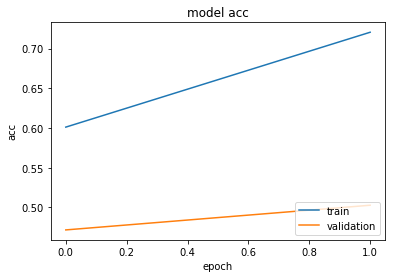

In [18]:
BATCH_SIZE = 64
EPOCH_SIZE = 1

training_batch_generator = batch_generator(True)
testing_batch_generator = batch_generator(False)

filepath="checkpoints/%s-weights-{epoch:02d}-{loss:.4f}.hdf5" % FILENAME
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min') # , verbose=1
reduce_LR = ReduceLROnPlateau(monitor='loss',factor = 0.9, patience=3,cooldown=2, min_lr = 0.00001)
early_stopping = EarlyStopping(monitor='val_acc', patience=50) #, min_delta=0.0001)
callbacks_list = [checkpoint ]# reduce_LR, early_stopping] # 

history = bidirectional_concat_model.fit_generator(
    training_batch_generator,
    steps_per_epoch=BATCH_SIZE,
    validation_data=testing_batch_generator,
    validation_steps=BATCH_SIZE/4,
    epochs=EPOCH_SIZE,
    callbacks=callbacks_list
)

list_of_histories.append(history)
plot_train(list_of_histories)

354/354 [==============================] - 1s
Model Accuracy = 0.50
Model Loss = 0.01


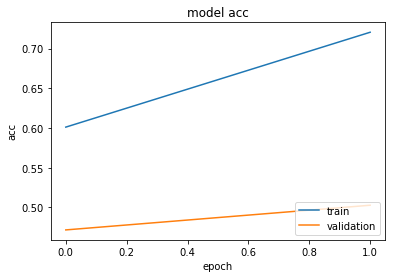

In [19]:
bidirectional_concat_model.save(FILENAME + ".h5")
save_list_of_histories(list_of_histories, FILENAME + ".histories")

x_test, y_test = next(testing_batch_generator)
evaluation = bidirectional_concat_model.evaluate(x_test, y_test,
          batch_size=x_test.shape[0])

print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))
plot_train(list_of_histories)

In [20]:
def decode_learning_objectives_from_regression(encoded_batch):
    encoded_batch = np.array(encoded_batch)
    encoded_batch = encoded_batch * 380    
    encoded_batch = encoded_batch.astype("uint8");
    return encoded_batch

def decode_learning_objectives_from_all_LOs(encoded_batch):
    encoded_batch = list(map(
        lambda encoded: np.argmax(encoded), # [i for i, x in enumerate(encoded) if x >= 0.05],
        encoded_batch
    ))
    return encoded_batch

def decode_learning_objectives_in_used_from_binary_categories(encoded_batch):
    encoded_batch = list(map(
        lambda encoded: [
            LEARNING_OBJECTIVES_IN_USED[i] for i, x in enumerate(encoded) if x >= 0.0001
        ],
        encoded_batch
    ))
    return encoded_batch

def decode_from_one_hot(encoded_batch):
    encoded_batch = list(map(
        lambda encoded: np.argmax(encoded),
        encoded_batch
    ))
    return encoded_batch

def decode_learning_objectives_in_used_from_index(encoded_batch):
    encoded_batch = list(map(
        lambda encoded: [
            LEARNING_OBJECTIVES_IN_USED[encoded]
        ],
        encoded_batch
    ))
    return encoded_batch

def predict_with_model(model):
    test, actual = next(testing_batch_generator)
    test = test[0:5]
    actual = actual[0:5]
    
    preds = model.predict(test)
    
    # LEARNING_OBJECTIVES_ENCODING = "first_LO-one_hot"
    # LEARNING_OBJECTIVES_ENCODING = "all_LOs-multi_hot"
    # LEARNING_OBJECTIVES_ENCODING = "first_used_LO-one_hot"
    # LEARNING_OBJECTIVES_ENCODING = "all_used_LOs-multi_hot"
    # LEARNING_OBJECTIVES_ENCODING = "regression"

    if OUTPUT_TYPES == "chapter":
        preds = decode_from_one_hot(preds)
        actual = decode_from_one_hot(actual)
    else:
        if LEARNING_OBJECTIVES_ENCODING == "all_used_LOs-multi_hot":
            preds = decode_learning_objectives_in_used_from_binary_categories(preds)
            actual = decode_from_one_hot(actual)
        elif LEARNING_OBJECTIVES_ENCODING == "first_used_LO-one_hot":
            preds = decode_from_one_hot(preds)
            actual = decode_from_one_hot(actual)
            preds = decode_learning_objectives_in_used_from_index(preds)
            actual = decode_learning_objectives_in_used_from_index(actual)
#     preds = model.predict(test)
#     print(preds)
        
#     if NUM_OF_LEARNING_OBJECTIVES == "all_in_binary_categories":
#         # all Los in binary categories
#         preds = decode_learning_objectives_from_multi_hot(preds)
#         actual = decode_learning_objectives_from_multi_hot(actual)
#     elif NUM_OF_LEARNING_OBJECTIVES == "all_used_in_binary_categories":
#         # all Los in binary categories
#         preds = decode_learning_objectives_in_used_from_binary_categories(preds)
#         actual = decode_learning_objectives_in_used_from_binary_categories(actual)
#     else:        
#         # LOs as regression
#         preds = decode_learning_objectives_from_regression(preds)
#         actual = decode_learning_objectives_from_regression(actual)
    
    actual = [str(act) for act in actual]
    preds = [str(pred) for pred in preds]
    
    df = pd.DataFrame({
        'Actual': actual,
        'Predicted': preds
    })
    print(df)

    
predict_with_model(bidirectional_concat_model)

  Actual Predicted
0  [9]    [5]     
1  [158]  [60]    
2  [102]  [113]   
3  [158]  [158]   
4  [94]   [295]   


In [21]:
# LEARNING_OBJECTIVES_ENCODING = "first_LO-one_hot"
# LEARNING_OBJECTIVES_ENCODING = "all_LOs-multi_hot"
LEARNING_OBJECTIVES_ENCODING = "first_used_LO-one_hot"
# LEARNING_OBJECTIVES_ENCODING = "all_used_LOs-multi_hot"
# LEARNING_OBJECTIVES_ENCODING = "regression"